## Intro 

In [19]:
# Libraries
import pandas as pd
import os
from datetime import datetime,timedelta
import warnings
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew #statistics for normality and skewness
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, brier_score_loss
# We will be using the accuracy, precision,recall, f1 and the brier score as scores to asses our model performence
#Importing basic alogorithm 
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC#we will not be using SVM due tot he huge training time required on our dataset.
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis,LinearDiscriminantAnalysis
from sklearn import model_selection #Cross-validation multiple scoring function
from pandas_profiling import ProfileReport
ip = get_ipython()
ibe = ip.configurables[-1]
ibe.figure_formats = { 'pdf', 'png'}
warnings.filterwarnings("ignore")
# Data
DATA_DIR='/Users/seangolbad/tennislytics'
df_atp = pd.read_csv(os.path.join(DATA_DIR,"df_atp.csv"),index_col=0)
df_atp["Date"] =df_atp.Date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
df_atp=df_atp.sort_values(by='Date')

## Pandas Profiling

In [36]:
#defining the library
profile = ProfileReport(df_atp)
# exporting your report as a html file
profile.to_file(output_file='atp_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

##### We drop the ATP column (Tournament number (men)) because it does seem intuitively unimportant.

In [20]:
#verifying the shape of the dataset before droping the 'ATP' column.
print("Shape of the Dataset before droping the 'ATP' Column : {} ".format(df_atp.shape))

#Saving the column (maybe for later use ?)
df_atp_ID = df_atp['ATP']

#Droping the column 
df_atp.drop("ATP", axis = 1, inplace = True)

#verifying the shape of the dataset after droping the 'ATP' column
print("\nShape of the Dataset after droping the 'ATP' Column : {} ".format(df_atp.shape))

Shape of the Dataset before droping the 'ATP' Column : (55669, 54) 

Shape of the Dataset after droping the 'ATP' Column : (55669, 53) 


### Quick glumpse at the data

In [38]:
print("'Federer R.'  have won " + str(len(df_atp[df_atp['Winner']=='Federer R.']) )+" and lost " +str(len(df_atp[df_atp['Loser']=='Federer R.' ])))
print("'Nadal R.'    have won " + str(len(df_atp[df_atp['Winner']=='Nadal R.'])) +" and lost " +str(len(df_atp[df_atp['Loser']=='Nadal R.' ])))
print("'Djokovic N.' have won " + str(len(df_atp[df_atp['Winner']=='Djokovic N.'])) +" and lost " +str(len(df_atp[df_atp['Loser']=='Djokovic N.' ])))
print("'Lopez F.'    have won " + str(len(df_atp[df_atp['Winner']=='Lopez F.'])) +" and lost " +str(len(df_atp[df_atp['Loser']=='Lopez F.' ])))
print("'Youzhny M.'  have won " + str(len(df_atp[df_atp['Winner']=='Youzhny M.'])) +" and lost " +str(len(df_atp[df_atp['Loser']=='Youzhny M.' ])))
print("'Verdasco F.' have won " + str(len(df_atp[df_atp['Winner']=='Verdasco F.'])) +" and lost " +str(len(df_atp[df_atp['Loser']=='Verdasco F.' ])))

'Federer R.'  have won 1177 and lost 242
'Nadal R.'    have won 952 and lost 198
'Djokovic N.' have won 876 and lost 175
'Lopez F.'    have won 481 and lost 436
'Youzhny M.'  have won 471 and lost 401
'Verdasco F.' have won 536 and lost 412


In [21]:
unique_player_index_and_score = {}
#Dictionary containing the player name as a key and the tuple (player_unique_index,x,y)
#x : number_of_matches_won
#y : number_of_matches played
# x and y are intiated 0 in the beginning but as we go through the data set we increment x and y by 1 if the player wins a match
# or we increment only y with 1 if the player loses a matches
i=0
for player in df_atp['Winner'].unique():
    if player not in unique_player_index_and_score.keys():
        unique_player_index_and_score[player] = (i,0,0)
        i+=1
for player in df_atp['Loser'].unique():
    if player not in unique_player_index_and_score.keys():
        unique_player_index_and_score[player] = (i,0,0)
        i+=1
        
print('Number of unqiue player names : ',i)

Number of unqiue player names :  1541


In [22]:
winner_loser_score_tracking_vector = np.zeros((len(df_atp),2)) 
# two columns one to track the winner percetage and the other for the loser percentage 
for c,row in enumerate(df_atp[['Winner','Loser']].values):
    score_winner = unique_player_index_and_score[row[0]]#Winner up-to date score tracking from the dictionary 
    score_loser = unique_player_index_and_score[row[1]]#Loser up-to date score tracking from the dictionary
    #we consider new player that haven't yet played 5 matches as the have 20% of winning in the past 
    #(kind of a fair approach as they worked hard to get to play in the tournament:))
    if score_winner[2]<5:
        winner_loser_score_tracking_vector[c,0]=0.2
    else:
        winner_loser_score_tracking_vector[c,0]=score_winner[1]/score_winner[2]
    if score_loser[2]<5:
        winner_loser_score_tracking_vector[c,1]=0.2
    else:
        winner_loser_score_tracking_vector[c,1]=score_loser[1]/score_loser[2]
    #updating the dictionary based on the new outcome of the current match
    unique_player_index_and_score[row[0]] = (score_winner[0],score_winner[1]+1,score_winner[2]+1)#Winner
    unique_player_index_and_score[row[1]] = (score_loser[0],score_loser[1],score_loser[2]+1)#loser

df_atp['Winner_percentage'] = winner_loser_score_tracking_vector[:,0]
df_atp['Loser_percentage'] = winner_loser_score_tracking_vector[:,1]

In [23]:
train_na = (df_atp.isnull().sum() / len(df_atp)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Percentage of missing values' :train_na})
missing_data

,Percentage of missing values
B&WL,98.029424
B&WW,98.029424
W5,96.513320
L5,96.513320
GBW,90.919542
GBL,90.919542
W4,90.800984
L4,90.800984
SBL,90.256696
SBW,90.256696


## Missing Data 

Text(0.5, 1.0, 'Percentage of missing values by variables')

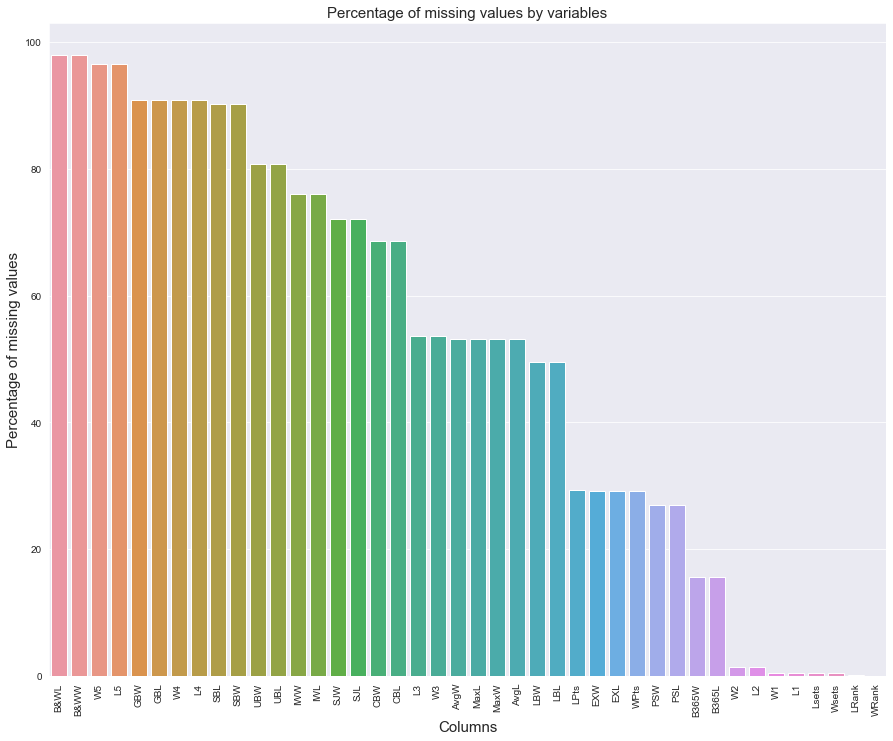

In [24]:
#With a visiualisation:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Columns', fontsize=15)
plt.ylabel('Percentage of missing values', fontsize=15)
plt.title('Percentage of missing values by variables', fontsize=15)

Some explications about this missing values:

Most of the columns with big missing values are from the odds of betting sites: we shall remove all these columns and keep the columns of the three betting sites : Bet365, EX and PS. First we are going to train a model with data containing these values and also another one with data not containing these values to see its effects on our score. We will be using thoses to also calculate how much we'll win or lose in we used a very simple betting stategy based on the prediction of our model :)

The columns L5,L4,W4,W5 (Number of games won in 5th\4th set by match winner\loser respectivly) have missing values because some matches have only 'best out of 3sets' rule while some have 'best out of 5sets' rules.

We can think intuitively that we can't use either the columns L1 through L5 or W5 through W1 in our predictive modeling phase training data as those variable are set after the matches finishes and we'll be using a discriminative approach in our modeling. So we'll remove those columns too. We can maybe use them if we want to calculate a modified wining set prior probability of each player (in a more advanced modelisation we can think of predicting those values).

The following columns:

MaxW= Maximum odds of match winner (as shown by Oddsportal.com)
MaxL= Maximum odds of match loser (as shown by Oddsportal.com)
AvgW= Average odds of match winner (as shown by Oddsportal.com)
AvgL= Average odds of match loser (as shown by Oddsportal.com)

The columns Lstes and Wsets wich mean Number of sets won by match loser/winner can't be used in as entry data to our model as they are too know after the moatches have finished. But, we we'll keep them to make another variable witch will be the prior probability of winning a sets in the past. We will replace the nan values by mean or median after we explore these columns.

As for Lrank or WRank columns, I can't imagine another senario as the one of a new player that just got for the first time in the tournements. we will replace those too by mean or median after we explore those columns too.

The same applies to the following columns :

WPts = ATP Entry points of the match winner as of the start of the tournament
LPts = ATP Entry points of the match loser as of the start of the tournament

In [25]:
#Drop the columns with missing values and that we won't be using:
for column in train_na.index[:18]:
    df_atp.drop(column, axis = 1, inplace = True)

In [26]:
df_atp.drop('W1', axis = 1, inplace = True)
df_atp.drop('L1', axis = 1, inplace = True)
df_atp.drop('W2', axis = 1, inplace = True)
df_atp.drop('L2', axis = 1, inplace = True)
df_atp.drop('W3', axis = 1, inplace = True)
df_atp.drop('L3', axis = 1, inplace = True)

Text(0.5, 1.0, 'Percentage of missing values by variables')

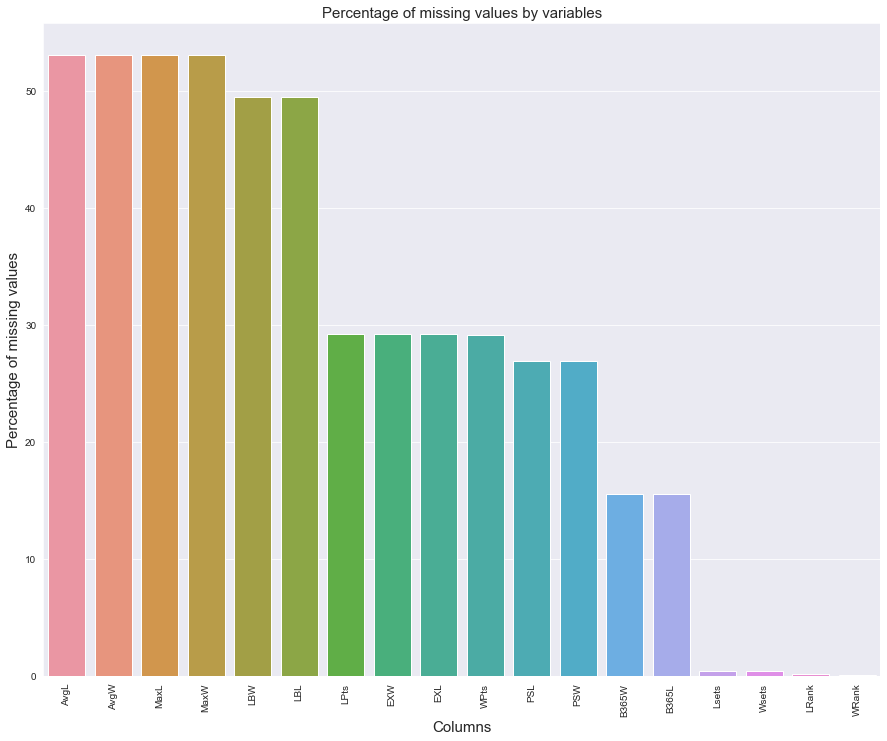

In [27]:
#With a visiualisation:
train_na = (df_atp.isnull().sum() / len(df_atp)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Pourcentage of missing values' :train_na})
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Columns', fontsize=15)
plt.ylabel('Percentage of missing values', fontsize=15)
plt.title('Percentage of missing values by variables', fontsize=15)

In [28]:
df_atp['EXW']=pd.to_numeric(df_atp['EXW'],errors='coerce')
df_atp['B365W']=pd.to_numeric(df_atp['B365W'],errors='coerce')
df_atp['B365L']=pd.to_numeric(df_atp['B365L'],errors='coerce')
df_atp['Wsets']=pd.to_numeric(df_atp['Wsets'],errors='coerce')
df_atp['Lsets']=pd.to_numeric(df_atp['Lsets'],errors='coerce')
df_atp['LRank']=pd.to_numeric(df_atp['LRank'],errors='coerce')
df_atp['WRank']=pd.to_numeric(df_atp['WRank'],errors='coerce')
df_atp['AvgL']=pd.to_numeric(df_atp['AvgL'],errors='coerce')
df_atp['AvgW']=pd.to_numeric(df_atp['AvgW'],errors='coerce')

In [29]:
columns=['WPts','LPts','PSW','PSL','EXW','EXL','B365W','B365L','Lsets','Wsets','LRank','WRank','MaxW','MaxL','AvgW','AvgL','LBW','LBL']
for column in columns:
    df_atp[column]=df_atp[column].fillna(float(df_atp[column].mode()[0]))

In [30]:
train_na = (df_atp.isnull().sum() / len(df_atp)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Percentage of missing values' :train_na})
missing_data

,Percentage of missing values


Description of the rest of the Data:

'B365L', 'B365W','EXL', 'EXW','PSL', 'PSW' : Just betting odds for wiiner and loser repsctivly.
'Bestof' : Maximum number of sets playable in match.
'Comment' :Comment on the match (Completed, won through retirement of loser, or via Walkover)
'Court' : Type of court (outdoors or indoors)
'Date' : date of the match obviously.
'WPts','LPts' : ATP Entry points of the match winner/loser as of the start of the tournament repectivly.
'Location' : Venue of tournament.
'Winner','Loser' : Name of winner/loser respectively.
'Wsets','Lsets' : Number of sets won by match winner/loser respectively
'Round' : Round of match
'Series' : Name of ATP tennis series (Grand Slam, Masters, International or International Gold)
'Surface' : Type of surface (clay, hard, carpet or grass)
'Tournament' : me of tounament (including sponsor if relevant)
'WRank','LRank' : ATP Entry ranking of the match winner/loser respectively as of the start of the tournament
'Winner_percentage','Loser_percentage': ...
As we said earlier, the column 'B365L', 'B365W','EXL', 'EXW','PSL', 'PSW' will be used in a our modelisationat first and we develop also the same models without those columns. We can think of these columns as some already calculated features given to us by the betting company.

The 'comment' column is an event that happend after the matches is finisehd so we'll not be using it too.

'Wsets' and 'Lsets' columns are that reprensents events that happens after the matche is finnished so we'll not be usig it in our model but we'll make of it a new column that reprensets the winner/loser percentage of winning a sets in the past.

All the rest of the columns will be used except maybe fot the tournement name and Location that we'll need to explore them first to see.

## More data processing for our datasets so we can use it for prediction and EDA 

In [31]:
#winner prior sets wins percentage column
unique_player_index_and_score = {}
#Dictionary containing the player name as a key and the tuple (player_unique_index,x,y)
#x : number_of_set_won
#y : number_of_sets_played
# x and y are intiated 0 in the bigining but as we go through the data set we increment x Wsets(or Lsets) witch are the number of
# won by matches winner(orloser) and we increment y by Wsets+Lsets wich is the number of stes played in that match
i=0
for player in df_atp['Winner'].unique():
    if player not in unique_player_index_and_score.keys():
        unique_player_index_and_score[player] = (i,0,0)
        i+=1
for player in df_atp['Loser'].unique():
    if player not in unique_player_index_and_score.keys():
        unique_player_index_and_score[player] = (i,0,0)
        i+=1
        
print('Number of unqiue player names : ',i)

winner_loser_score_tracking_vector = np.zeros((len(df_atp),2)) 
# two columns one to track the winner percetage and the other for the loser percentage 
df_atp=df_atp.sort_values(by='Date')
for i in range(len(df_atp)):
    row=[df_atp.Winner[i],df_atp.Loser[i]]
    score_winner = unique_player_index_and_score[row[0]]#Winner up-to date set win score tracking from the dictionary 
    score_loser = unique_player_index_and_score[row[1]]#Loser up-to date  set win score tracking from the dictionary
    #we consider new player that haven't yet had 15 sets yet as they had a 20% of winning in the past 
    #(kind of a fair optimist approach as the worked hard to get to play in the tournement:))
    if int(score_winner[2])<15:
        winner_loser_score_tracking_vector[i,0]=0.2
    else:
        winner_loser_score_tracking_vector[i,0] =score_winner[1]/score_winner[2]
    if score_loser[2]<15:
        winner_loser_score_tracking_vector[i,1]=0.2
    else:
        winner_loser_score_tracking_vector[i,1] = score_loser[1]/score_loser[2]
    #updating the dictionary based on the new outcome of the current match
    unique_player_index_and_score[row[0]] = (score_winner[0],score_winner[1]+float(df_atp.Wsets[i]),score_winner[2]+float(df_atp.Wsets[i]+df_atp.Lsets[i]))#Winner
    unique_player_index_and_score[row[1]] = (score_loser[0],score_loser[1]+float(df_atp.Lsets[i]),score_loser[2]+float(df_atp.Wsets[i]+df_atp.Lsets[i]))#loser
    
df_atp['Winner_set_percentage'] = winner_loser_score_tracking_vector[:,0]
df_atp['Loser_set_percentage'] = winner_loser_score_tracking_vector[:,1]

Number of unqiue player names :  1541


In [32]:
def compute_elo_rankings(data):
    """
    Given the list on matches in chronological order, for each match, computes 
    the elo ranking of the 2 players at the beginning of the match
    
    """
    print("Elo rankings computing...")
    players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index)
    elo=pd.Series(np.ones(len(players))*1500,index=players)
    ranking_elo=[(1500,1500)]
    for i in range(1,len(data)):
        w=data.iloc[i-1,:].Winner
        l=data.iloc[i-1,:].Loser
        elow=elo[w]
        elol=elo[l]
        pwin=1 / (1 + 10 ** ((elol - elow) / 400))    
        K_win=32
        K_los=32
        new_elow=elow+K_win*(1-pwin)
        new_elol=elol-K_los*(1-pwin)
        elo[w]=new_elow
        elo[l]=new_elol
        ranking_elo.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser])) 
        if i%5000==0:
            print(str(i)+" matches computed...")
    ranking_elo=pd.DataFrame(ranking_elo,columns=["elo_winner","elo_loser"])    
    ranking_elo["proba_elo"]=1 / (1 + 10 ** ((ranking_elo["elo_loser"] - ranking_elo["elo_winner"]) / 400))   
    return ranking_elo

In [33]:
Elo =  compute_elo_rankings(df_atp)

Elo rankings computing...
5000 matches computed...
10000 matches computed...
15000 matches computed...
20000 matches computed...
25000 matches computed...
30000 matches computed...
35000 matches computed...
40000 matches computed...
45000 matches computed...
50000 matches computed...
55000 matches computed...


In [34]:
df_atp["Elo_Winner"] = Elo["elo_winner"]
df_atp["Elo_Loser"] = Elo["elo_loser"]
df_atp["Proba_Elo"]= Elo["proba_elo"]

Calculating the Elo ranking features :
The Elo rating system is a method for calculating the relative skill levels of players in zero-sum games such as chess. It is named after its creator Arpad Elo, a Hungarian-American physics professor.

The difference in the ratings between two players serves as a predictor of the outcome of a match. Two players with equal ratings who play against each other are expected to score an equal number of wins. A player whose rating is 100 points greater than their opponent's is expected to score 64%; if the difference is 200 points, then the expected score for the stronger player is 76%

One last transformation of our data to augmented it and in the mean time to make it ready for modelization and to explore it more too.

-For each row describing a match we'll be having two resulting row. One with target variable 1 and we keep the columns as they are and one with the target variable 0 we put the invert the column of the winner with that of the loser and the column of the loser with that of the winner and we keep the rest of the columns as they are. That will double the amount of our training data and will also transform our problem to a binary classification problem.

In [35]:
target_1 = np.ones(len(df_atp))
target_2 = np.zeros(len(df_atp))
target_1 = pd.DataFrame(target_1,columns=['label'])
target_2 = pd.DataFrame(target_2,columns=['label'])

In [36]:
features_categorical = df_atp[["Series","Court","Surface","Round","Best of","Tournament"]].copy()
features_onehot = pd.get_dummies(features_categorical)
#tournaments_encoded = features_tournaments_encoding(df_atp)
#features_binary = pd.concat([features_categorical_encoded,tournaments_encoded],1)

## For the moment we have one row per match. 
## We "duplicate" each row to have one row for each outcome of each match. 
## Of course it isn't a simple duplication of each row, we need to "invert" some features

# Elo data
elo_rankings = df_atp[["Elo_Winner","Elo_Loser","Proba_Elo"]]
elo_1 = elo_rankings
elo_2 = elo_1[["Elo_Loser","Elo_Winner","Proba_Elo"]]
elo_2.columns = ["Elo_Winner","Elo_Loser","Proba_Elo"]
elo_2.Proba_Elo = 1-elo_2.Proba_Elo
# Player prior win probability
win_percentage = df_atp[['Winner_percentage', 'Loser_percentage']]
win_1 = win_percentage
win_2 = win_1[['Loser_percentage','Winner_percentage']]
win_2.columns = ['Winner_percentage', 'Loser_percentage']
# Player prior win set probability
set_win_percentage = df_atp[['Winner_set_percentage','Loser_set_percentage']]
set_1 = set_win_percentage
set_2 = set_1[['Loser_set_percentage','Winner_set_percentage']]
set_2.columns = ['Winner_set_percentage','Loser_set_percentage']
# Player entry points
Pts = df_atp[['WPts','LPts']]
Pts_1 = Pts
Pts_2 = Pts_1[['LPts','WPts']]
Pts_2.columns = ['WPts','LPts']
# Player Entry Ranking
Rank = df_atp[['WRank','LRank']]
Rank_1 = Rank
Rank_2 = Rank_1[['LRank','WRank']]
Rank_2.columns = ['LRank','WRank']
#Player Odds for winning
Odds = df_atp[['EXW','EXL','PSW','PSL','B365W','B365L']]
Odds_1 = Odds
Odds_2 = Odds_1[['EXL','EXW','PSL','PSW','B365L','B365W']]
Odds_2.columns = ['EXW','EXL','PSW','PSL','B365W','B365L']
#Date 
Date_1 = df_atp.Date
Date_2 = df_atp.Date
elo_2.index = range(1,2*len(elo_1),2)
elo_1.index = range(0,2*len(elo_1),2)
win_1.index = range(0,2*len(win_1),2)
win_2.index = range(0,2*len(win_1),2)
set_1.index = range(0,2*len(set_1),2)
set_2.index = range(0,2*len(set_1),2)
Pts_1.index = range(0,2*len(Pts_1),2)
Pts_2.index = range(0,2*len(Pts_1),2)
Rank_1.index = range(0,2*len(Rank_1),2)
Rank_2.index = range(0,2*len(Rank_1),2)
Odds_1.index = range(0,2*len(Odds_1),2)
Odds_2.index = range(0,2*len(Odds_1),2)
Date_1.index = range(0,2*len(Date_1),2)
Date_2.index = range(0,2*len(Date_1),2)
target_1.index = range(0,2*len(target_1),2)
target_2.index = range(0,2*len(target_1),2)
features_elo_ranking = pd.concat([elo_1,elo_2]).sort_index(kind='merge')
features_win_percentage = pd.concat([win_1,win_2]).sort_index(kind='merge')
features_set_percentage = pd.concat([set_1,set_2]).sort_index(kind='merge')
features_Pts = pd.concat([Pts_1,Pts_2]).sort_index(kind='merge')
features_Rank =  pd.concat([Rank_1,Rank_2]).sort_index(kind='merge')
features_Odds = pd.concat([Odds_1,Odds_2]).sort_index(kind='merge')
target = pd.concat([target_1,target_2]).sort_index(kind='merge')
Date = pd.concat([Date_1,Date_2]).sort_index(kind='merge').to_frame()
'''
features_Odds.reset_index(drop=True, inplace=True)
features_elo_ranking.reset_index(drop=True, inplace=True)
#features_onehot.reset_index(drop=True, inplace=True)
features_win_pourcentage.reset_index(drop=True, inplace=True)
features_set_pourcentage.reset_index(drop=True, inplace=True)
features_set_pourcentage.reset_index(drop=True, inplace=True)
features_Pts.reset_index(drop=True, inplace=True)
features_Rank.reset_index(drop=True, inplace=True)
features_Odds.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)
'''
features_onehot = pd.DataFrame(np.repeat(features_onehot.values,2, axis=0),columns=features_onehot.columns)
features_onehot.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_Odds.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_elo_ranking.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_win_percentage.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_set_percentage.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_Pts.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_Rank.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
features_Odds.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
target.set_index(pd.Series(range(0,2*len(df_atp))), inplace=True)
Date.set_index(pd.Series(range(0,2*len(df_atp))),inplace=True)
### Building of the pre final dataset 
# We can remove some features to see the effect on our model
features = pd.concat([features_win_percentage,
                  features_set_percentage,
                  features_elo_ranking,
                  features_Pts,
                  features_Rank,
                  features_Odds,
                  features_onehot,
                  Date,
                  target], axis=1)

In [33]:
#Setting the 2019 matches as the test dataset.
#beg = datetime(2016,1,1)
end_train = datetime(2019,1,1)
beg_test = datetime(2019,1,1)
end_test = datetime(2020,1,1)
train = features[features['Date']<end_train]
test = features[(features['Date']>=beg_test)&(features['Date']<end_test)]

# Modeling

Text(0.5, 0, 'Relevance Percentage')

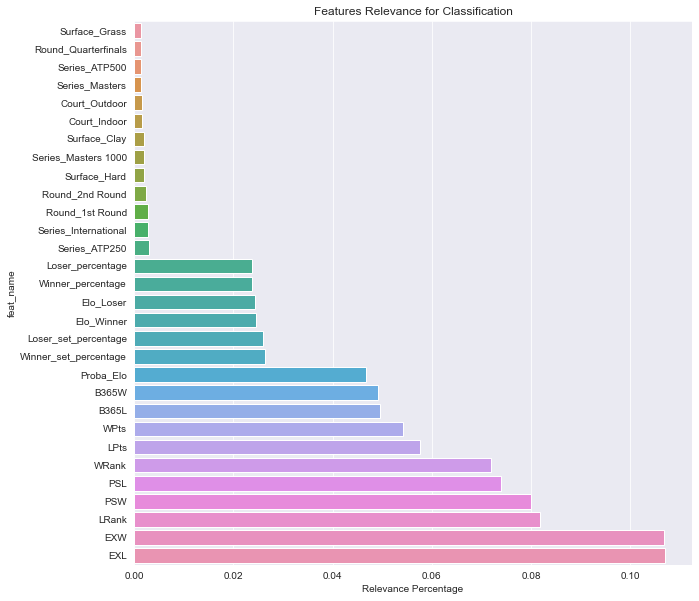

In [91]:
df = features.drop(columns=['Date','label'])
feat_forest = RandomForestClassifier(n_jobs=-1)
feat_forest.fit(X=df, y=features['label'])

plt.figure(figsize=(10, 10))
feat_imp = feat_forest.feature_importances_

feat_imp, cols = zip(*sorted(zip(feat_imp, df.columns)))
feat_imp = np.array(feat_imp)[-30:]
cols = np.array(cols)[-30:]
d = {'feat_name': cols
    ,'feat_imp': feat_imp }
importance =  pd.DataFrame(data=d)
sns.barplot( x=  importance['feat_imp'],y = importance['feat_name']
           );
plt.yticks(range(len(cols[-30:])), cols[-30:])
plt.title("Features Relevance for Classification")
plt.xlabel("Relevance Percentage")

In [62]:
#features.drop(Odds_1.columns,axis=1,inplace=True)
X = train.drop(columns=['Date','label'])
Y = train['label']
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegression()))

# evaluate each model in turn

results = []
scoring = {'accuracy': make_scorer(accuracy_score),
          'precision_score': make_scorer(precision_score),
          'recall_score' : make_scorer(recall_score),
          'f1_score' : make_scorer(f1_score),
          'brier_score_loss' : make_scorer(brier_score_loss)}
names = []
for name, model in models:
    stratifiedKFold = model_selection.StratifiedKFold(n_splits=10)
    cv_results = model_selection.cross_validate(model, X, Y, cv=stratifiedKFold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
    msg ='-------------------------------------------------------------------------------------------------------------\n'
    msg = "Model : %s \n" % (name)
    msg = msg +'\n'
    msg =  msg + "Accuracy :  %f (%f)\n" % (cv_results['test_accuracy'].mean(),cv_results['test_accuracy'].std())
    msg =  msg + "Precision score :  %f (%f)\n" % (cv_results['test_precision_score'].mean(),cv_results['test_precision_score'].std())
    msg =  msg + "Recall score :  %f (%f)\n" % (cv_results['test_recall_score'].mean(),cv_results['test_recall_score'].std())
    msg =  msg + "F1 score :  %f (%f)\n" % (cv_results['test_f1_score'].mean(),cv_results['test_f1_score'].std())
    msg =  msg + "Brier score loss :  %f (%f)\n" % (cv_results['test_brier_score_loss'].mean(),cv_results['test_brier_score_loss'].std())
    msg = msg + '------------------------------------------------------------------------------------------------------------\n'
    print(msg)

Model : LR 

Accuracy :  0.499981 (0.000044)
Precision score :  0.299990 (0.244941)
Recall score :  0.438690 (0.452181)
F1 score :  0.324768 (0.301532)
Brier score loss :  0.500019 (0.000044)
------------------------------------------------------------------------------------------------------------



In [ ]:
#Logistic Regression model with ranks
#Brier score loss : 0.23

In [25]:
#features.drop(Odds_1.columns,axis=1,inplace=True)
X = train.drop(columns=['Date','label'])
Y = train['label']
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegression()))

# evaluate each model in turn

results = []
scoring = {'accuracy': make_scorer(accuracy_score),
          'precision_score': make_scorer(precision_score),
          'recall_score' : make_scorer(recall_score),
          'f1_score' : make_scorer(f1_score),
          'brier_score_loss' : make_scorer(brier_score_loss)}
names = []
for name, model in models:
    stratifiedKFold = model_selection.StratifiedKFold(n_splits=10)
    cv_results = model_selection.cross_validate(model, X, Y, cv=stratifiedKFold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
    msg ='-------------------------------------------------------------------------------------------------------------\n'
    msg = "Model : %s \n" % (name)
    msg = msg +'\n'
    msg =  msg + "Accuracy :  %f (%f)\n" % (cv_results['test_accuracy'].mean(),cv_results['test_accuracy'].std())
    msg =  msg + "Precision score :  %f (%f)\n" % (cv_results['test_precision_score'].mean(),cv_results['test_precision_score'].std())
    msg =  msg + "Recall score :  %f (%f)\n" % (cv_results['test_recall_score'].mean(),cv_results['test_recall_score'].std())
    msg =  msg + "F1 score :  %f (%f)\n" % (cv_results['test_f1_score'].mean(),cv_results['test_f1_score'].std())
    msg =  msg + "Brier score loss :  %f (%f)\n" % (cv_results['test_brier_score_loss'].mean(),cv_results['test_brier_score_loss'].std())
    msg = msg + '------------------------------------------------------------------------------------------------------------\n'
    print(msg)

Model : LR 

Accuracy :  0.769970 (0.108087)
Precision score :  0.769930 (0.108124)
Recall score :  0.770060 (0.108016)
F1 score :  0.769995 (0.108070)
Brier score loss :  0.230030 (0.108087)
------------------------------------------------------------------------------------------------------------



In [ ]:
#Logistic Regression with elo ratings added to rank
#Brier score loss : 0.23 (significant improvement over simplest model)

In [28]:
#features.drop(Odds_1.columns,axis=1,inplace=True)
X = train.drop(columns=['Date','label'])
Y = train['label']
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegression()))

# evaluate each model in turn

results = []
scoring = {'accuracy': make_scorer(accuracy_score),
          'precision_score': make_scorer(precision_score),
          'recall_score' : make_scorer(recall_score),
          'f1_score' : make_scorer(f1_score),
          'brier_score_loss' : make_scorer(brier_score_loss)}
names = []
for name, model in models:
    stratifiedKFold = model_selection.StratifiedKFold(n_splits=10)
    cv_results = model_selection.cross_validate(model, X, Y, cv=stratifiedKFold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
    msg ='-------------------------------------------------------------------------------------------------------------\n'
    msg = "Model : %s \n" % (name)
    msg = msg +'\n'
    msg =  msg + "Accuracy :  %f (%f)\n" % (cv_results['test_accuracy'].mean(),cv_results['test_accuracy'].std())
    msg =  msg + "Precision score :  %f (%f)\n" % (cv_results['test_precision_score'].mean(),cv_results['test_precision_score'].std())
    msg =  msg + "Recall score :  %f (%f)\n" % (cv_results['test_recall_score'].mean(),cv_results['test_recall_score'].std())
    msg =  msg + "F1 score :  %f (%f)\n" % (cv_results['test_f1_score'].mean(),cv_results['test_f1_score'].std())
    msg =  msg + "Brier score loss :  %f (%f)\n" % (cv_results['test_brier_score_loss'].mean(),cv_results['test_brier_score_loss'].std())
    msg = msg + '------------------------------------------------------------------------------------------------------------\n'
    print(msg)

Model : LR 

Accuracy :  0.776833 (0.060322)
Precision score :  0.776789 (0.060383)
Recall score :  0.776925 (0.060228)
F1 score :  0.776857 (0.060305)
Brier score loss :  0.223167 (0.060322)
------------------------------------------------------------------------------------------------------------



In [31]:
#features.drop(Odds_1.columns,axis=1,inplace=True)
X = train.drop(columns=['Date','label'])
Y = train['label']
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegression()))

# evaluate each model in turn

results = []
scoring = {'accuracy': make_scorer(accuracy_score),
          'precision_score': make_scorer(precision_score),
          'recall_score' : make_scorer(recall_score),
          'f1_score' : make_scorer(f1_score),
          'brier_score_loss' : make_scorer(brier_score_loss)}
names = []
for name, model in models:
    stratifiedKFold = model_selection.StratifiedKFold(n_splits=10)
    cv_results = model_selection.cross_validate(model, X, Y, cv=stratifiedKFold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
    msg ='-------------------------------------------------------------------------------------------------------------\n'
    msg = "Model : %s \n" % (name)
    msg = msg +'\n'
    msg =  msg + "Accuracy :  %f (%f)\n" % (cv_results['test_accuracy'].mean(),cv_results['test_accuracy'].std())
    msg =  msg + "Precision score :  %f (%f)\n" % (cv_results['test_precision_score'].mean(),cv_results['test_precision_score'].std())
    msg =  msg + "Recall score :  %f (%f)\n" % (cv_results['test_recall_score'].mean(),cv_results['test_recall_score'].std())
    msg =  msg + "F1 score :  %f (%f)\n" % (cv_results['test_f1_score'].mean(),cv_results['test_f1_score'].std())
    msg =  msg + "Brier score loss :  %f (%f)\n" % (cv_results['test_brier_score_loss'].mean(),cv_results['test_brier_score_loss'].std())
    msg = msg + '------------------------------------------------------------------------------------------------------------\n'
    print(msg)

Model : LR 

Accuracy :  0.777712 (0.061681)
Precision score :  0.777744 (0.061608)
Recall score :  0.777613 (0.061835)
F1 score :  0.777678 (0.061721)
Brier score loss :  0.222288 (0.061681)
------------------------------------------------------------------------------------------------------------



In [34]:
#features.drop(Odds_1.columns,axis=1,inplace=True)
X = train.drop(columns=['Date','label'])
Y = train['label']
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegression()))

# evaluate each model in turn

results = []
scoring = {'accuracy': make_scorer(accuracy_score),
          'precision_score': make_scorer(precision_score),
          'recall_score' : make_scorer(recall_score),
          'f1_score' : make_scorer(f1_score),
          'brier_score_loss' : make_scorer(brier_score_loss)}
names = []
for name, model in models:
    stratifiedKFold = model_selection.StratifiedKFold(n_splits=10)
    cv_results = model_selection.cross_validate(model, X, Y, cv=stratifiedKFold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
    msg ='-------------------------------------------------------------------------------------------------------------\n'
    msg = "Model : %s \n" % (name)
    msg = msg +'\n'
    msg =  msg + "Accuracy :  %f (%f)\n" % (cv_results['test_accuracy'].mean(),cv_results['test_accuracy'].std())
    msg =  msg + "Precision score :  %f (%f)\n" % (cv_results['test_precision_score'].mean(),cv_results['test_precision_score'].std())
    msg =  msg + "Recall score :  %f (%f)\n" % (cv_results['test_recall_score'].mean(),cv_results['test_recall_score'].std())
    msg =  msg + "F1 score :  %f (%f)\n" % (cv_results['test_f1_score'].mean(),cv_results['test_f1_score'].std())
    msg =  msg + "Brier score loss :  %f (%f)\n" % (cv_results['test_brier_score_loss'].mean(),cv_results['test_brier_score_loss'].std())
    msg = msg + '------------------------------------------------------------------------------------------------------------\n'
    print(msg)

Model : LR 

Accuracy :  0.784813 (0.061018)
Precision score :  0.783582 (0.060010)
Recall score :  0.786750 (0.062146)
F1 score :  0.785159 (0.061055)
Brier score loss :  0.215187 (0.061018)
------------------------------------------------------------------------------------------------------------



In [92]:
#features.drop(Odds_1.columns,axis=1,inplace=True)
X = train.drop(columns=['Date','label','EXW', 'EXL', 'PSW', 'PSL', 'B365W', 'B365L'])
Y = train['label']
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA',QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(5, n_jobs=-1)))
models.append(('CART', DecisionTreeClassifier(max_depth=10)))
models.append(('NB', GaussianNB()))
#models.append(('SVM_linear', SVC(kernel="linear", C=0.025)))
#models.append(('SVM_',SVC(gamma=2, C=1)))
models.append(('RandomForest',RandomForestClassifier( n_estimators=100, n_jobs=-1)))
models.append(('MLP',MLPClassifier(alpha=0.0001)))
models.append(('ADABoost',AdaBoostClassifier()))

# evaluate each model in turn

results = []
scoring = {'accuracy': make_scorer(accuracy_score),
          'precision_score': make_scorer(precision_score),
          'recall_score' : make_scorer(recall_score),
          'f1_score' : make_scorer(f1_score),
          'brier_score_loss' : make_scorer(brier_score_loss)}
names = []
for name, model in models:
    stratifiedKFold = model_selection.StratifiedKFold(n_splits=10)
    cv_results = model_selection.cross_validate(model, X, Y, cv=stratifiedKFold, scoring=scoring) 
    results.append(cv_results)
    names.append(name)
    msg ='-------------------------------------------------------------------------------------------------------------\n'
    msg = "Model : %s \n" % (name)
    msg = msg +'\n'
    msg =  msg + "Accuracy :  %f (%f)\n" % (cv_results['test_accuracy'].mean(),cv_results['test_accuracy'].std())
    msg =  msg + "Precision score :  %f (%f)\n" % (cv_results['test_precision_score'].mean(),cv_results['test_precision_score'].std())
    msg =  msg + "Recall score :  %f (%f)\n" % (cv_results['test_recall_score'].mean(),cv_results['test_recall_score'].std())
    msg =  msg + "F1 score :  %f (%f)\n" % (cv_results['test_f1_score'].mean(),cv_results['test_f1_score'].std())
    msg =  msg + "Brier score loss :  %f (%f)\n" % (cv_results['test_brier_score_loss'].mean(),cv_results['test_brier_score_loss'].std())
    msg = msg + '------------------------------------------------------------------------------------------------------------\n'
    print(msg)

Model : LR 

Accuracy :  0.725413 (0.033368)
Precision score :  0.725261 (0.033236)
Recall score :  0.725720 (0.033593)
F1 score :  0.725490 (0.033413)
Brier score loss :  0.274587 (0.033368)
------------------------------------------------------------------------------------------------------------

Model : LDA 

Accuracy :  0.735774 (0.034651)
Precision score :  0.735756 (0.034623)
Recall score :  0.735814 (0.034660)
F1 score :  0.735785 (0.034640)
Brier score loss :  0.264226 (0.034651)
------------------------------------------------------------------------------------------------------------

Model : QDA 

Accuracy :  0.530441 (0.038569)
Precision score :  0.591733 (0.089230)
Recall score :  0.278499 (0.267995)
F1 score :  0.308469 (0.206601)
Brier score loss :  0.469559 (0.038569)
------------------------------------------------------------------------------------------------------------

Model : KNN 

Accuracy :  0.885931 (0.049991)
Precision score :  0.885922 (0.050007)
Recall 

In [63]:
df_atp['MoneyL'] = (df_atp['AvgL']-1)*100 * (df_atp['AvgL'] >= 2) + (-100/(df_atp['AvgL']-1) * (df_atp['AvgL'] < 2))
df_atp['MoneyW'] = (df_atp['AvgW']-1)*100 * (df_atp['AvgW'] >= 2) + (-100/(df_atp['AvgW']-1) * (df_atp['AvgW'] < 2))

In [94]:
Accuracy = []
Precision = []
Recall = []
F1 = []
Brier = []
for idx,scores in enumerate(results):
    Accuracy.append(scores['test_accuracy'])
    Precision.append(scores['test_precision_score'])
    Recall.append(scores['test_recall_score'])
    F1.append(scores['test_f1_score'])
    Brier.append(scores['test_brier_score_loss'])

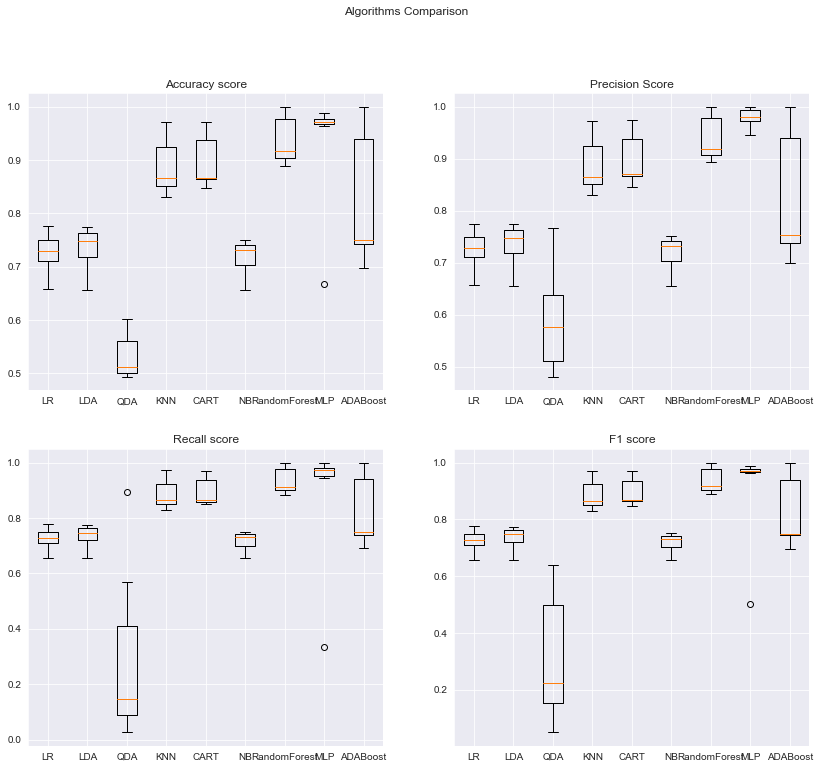

In [95]:
fig = plt.figure(figsize=(14,12))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(221)
plt.boxplot(Accuracy)
plt.title('Accuracy score')
ax.set_xticklabels(names)
ax = fig.add_subplot(222)
plt.boxplot(Precision)
plt.title('Precision Score')
ax.set_xticklabels(names)
ax = fig.add_subplot(223)
plt.boxplot(Recall)
ax.set_xticklabels(names)
plt.title('Recall score')
ax = fig.add_subplot(224)
plt.title('F1 score')
plt.boxplot(F1)
ax.set_xticklabels(names)

plt.show()

In [191]:
#now to test
from time import time

X_test = test.drop(columns=['Date','label','EXW', 'EXL', 'PSW', 'PSL', 'B365W', 'B365L'])
Y_test = test['label']

y_pred = []
train_time = []

for name, model in models:
    tic = time()
    model.fit(X, Y)
    toc = time()
    
    y_pred.append(model.predict(X_test))
    train_time.append(toc - tic)
    
    print("Classifier : {} ===> Training duration : {} sec".format(name, train_time[-1]))

Classifier : LR ===> Training duration : 3.725048780441284 sec
Classifier : LDA ===> Training duration : 6.360583782196045 sec
Classifier : QDA ===> Training duration : 4.26870322227478 sec
Classifier : KNN ===> Training duration : 1.472107172012329 sec
Classifier : CART ===> Training duration : 3.105231761932373 sec
Classifier : NB ===> Training duration : 1.798062801361084 sec
Classifier : RandomForest ===> Training duration : 11.719471216201782 sec
Classifier : MLP ===> Training duration : 544.8371620178223 sec
Classifier : ADABoost ===> Training duration : 91.97734713554382 sec


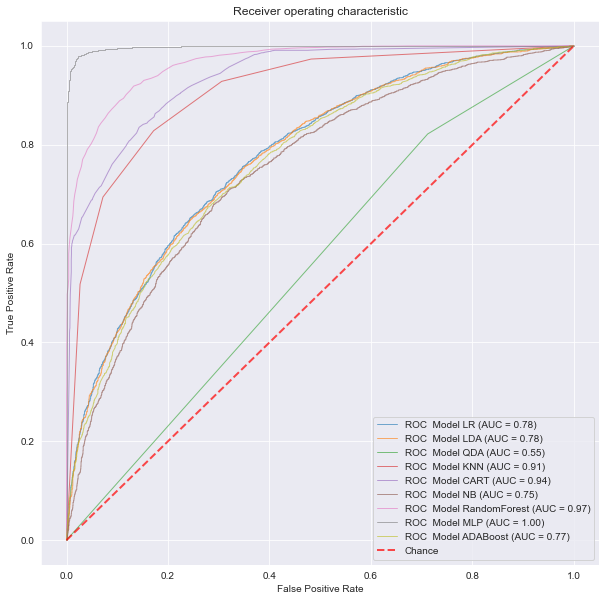

In [193]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

y_prob = []

for name, model in models:
    y_prob.append(model.predict_proba(X_test)[:,1])
    
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
plt.figure(figsize=(10,10))
for idx, y_clf in enumerate(y_prob):
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y_test, y_clf)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.6,
             label='ROC  Model %s (AUC = %0.2f)' % (models[idx][0], roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.7)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [195]:
betting_columns = ['EXL','EXW','PSL','PSW','B365L','B365W']
#Columns containg the Odds
Betting_Odds =  test[betting_columns]

#Our Capital will be 1500Euros for each strategy and for each betting site for a single model. 
budget_1 = 1500

In [197]:
#Our Capital will be 1500Euros for each strategy and for each betting site for a single model. 
reports = []
metrics = ["Classifier",  "Strat 1 EX", "Strat 2 EX", "Strat 1 PS", "Strat 2 PS", "Strat 1 B365", "Strat 2 B365" ,'Random EX', 'Random PS','Random B365']
for idx, y_clf in enumerate(y_pred):
    Random = simple_bettor(Betting_Odds ,Y_test,budget_1)
    strat_1 = strategy_1(Betting_Odds,y_clf,Y_test,budget_1)
    strat_2 = strategy_2(Betting_Odds,y_prob[idx],Y_test,budget_1)
    report = (models[idx][0],strat_1[1],strat_2[1],strat_1[1],strat_2[1],strat_1[2],strat_2[2],Random[0],Random[1],Random[2])
    reports.append(report)       
display(pd.DataFrame.from_records(reports, columns=metrics))

,Classifier,Strat 1 EX,Strat 2 EX,Strat 1 PS,Strat 2 PS,Strat 1 B365,Strat 2 B365,Random EX,Random PS,Random B365
0,LR,6.898067,3.727863,6.898067,3.727863,5.385293,2.247183,-1.0,-1.0,-1.0
1,LDA,7.305933,3.961040,7.305933,3.961040,5.754827,2.441990,-1.0,-1.0,-1.0
2,QDA,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0
3,KNN,17.277800,15.564973,17.277800,15.564973,15.159893,13.439987,-1.0,-1.0,-1.0
4,CART,21.171200,19.683210,21.171200,19.683210,18.585160,17.167167,-1.0,-1.0,-1.0
5,NB,6.640467,4.246445,6.640467,4.246445,5.143360,2.807080,-1.0,-1.0,-1.0
6,RandomForest,24.378533,15.118226,24.378533,15.118226,21.719360,12.900583,-1.0,-1.0,-1.0
7,MLP,30.498933,30.007517,30.498933,30.007517,27.538960,27.069071,-1.0,-1.0,-1.0
8,ADABoost,6.321333,-1.000000,6.321333,-1.000000,4.884227,-1.000000,-1.0,-1.0,-1.0
